In [1]:
import qiskit.aqua.operators as op
import numpy as np
from scipy.optimize import minimize
from qiskit import(QuantumCircuit, execute, Aer, ClassicalRegister, IBMQ, aqua)
from qiskit.circuit.library import Diagonal
from qiskit.visualization import plot_histogram
from qiskit.optimization.applications.ising import tsp

import time

On définit la classe suivante, qui sera utilisée pour construire les hamiltoniens :

In [2]:
class DiagOp:
    def __init__(self, liste): self.value = np.array(liste)
    def __add__(self, B): return DiagOp(self.value + B.value)
    def __sub__(self, B): return DiagOp(self.value - B.value)
    def __matmul__(self, B): return DiagOp(self.value * B.value)
    def __mul__(self, n): return DiagOp(n * self.value)
    def __rmul__(self, n): return DiagOp(n * self.value)
    def __invert__(self): return DiagOp(np.conjugate(self.value))
    def __neg__(self): return DiagOp( - self.value)
    def __xor__(self, B):
        if isinstance(B, DiagOp):
            return DiagOp(np.kron(self.value, B.value))
        if isinstance(B, int):
            n = B
            L = [1]
            for k in range(n):
                L = np.kron(L, self.value)
            return DiagOp(L)

    def evolCircuit(self, t):
        circuit = Diagonal(np.exp(- t * 1j * self.value))
        return circuit.copy('gamma = ' + str(t))

    def evolOp(self, t): return op.PrimitiveOp(self.evolCircuit(t).to_gate())

    def expectation(self, state):
        arr = state.to_matrix()
        mod = np.abs(arr) ** 2
        return np.sum(mod * self.value).real

Fonction permettant la construction du circuit du QAOA :

In [3]:
def TspQaoaCircuit(num_cities, p, symmetric = True):
    id = DiagOp([1, 1])
    z = DiagOp([1, -1])

    def bit(i, t): return t * num_cities + i

    def I(): return id ^ N
    def Z(b): return (id ^ b) ^ z ^ (id ^ (N - b - 1))

    def D(i, t):
        b = bit(i, t)
        return 0.5 * (I() - Z(b))

    def UDriver(t):
        circuitUDriver = QuantumCircuit(N)
        circuitUDriver.rx(2 * t, range(N))
        return circuitUDriver


    def buildDiagCost(pen, num_cities, weights):

        # constrainte (a) : chaque ville est visitée une et une seule fois
        H_a = DiagOp([0] * (2 ** N))
        for i in range(num_cities):
            cur = I()
            for t in range(num_cities):
                cur -= D(i, t)
            H_a += cur @ cur

        # constraint (b) : une et une seule ville par étape de temps
        H_b = DiagOp([0] * (2 ** N))
        for t in range(num_cities):
            cur = I()
            for i in range(num_cities):
                cur -= D(i, t)
            H_b += cur @ cur

        # constraint (d) : poids
        H_d = DiagOp([0] * (2 ** N))
        for i in range(num_cities):
            for j in range(num_cities):
                for t in range(num_cities - 1):
                    H_d += D(i, t) @ D(j, t + 1) * weights[i, j] * pen
                H_d += D(i, num_cities - 1) @ D(j, 0) * weights[i, j] * pen

        return H_a + H_b + H_d

    def buildCircuitDriver():
        circuit_driver = QuantumCircuit(N)
        for i in range(N): circuit_driver.x(i)
        return circuit_driver

    def buildQaoaCircuit(betas, gammas):
        qaoaCircuit = QuantumCircuit(N)
        for i in range(N):
            qaoaCircuit.x(i)
            qaoaCircuit.h(i)
        for k in range(p):
            qaoaCircuit.append(H_cost.evolCircuit(gammas[k]), range(N))
            qaoaCircuit.append(UDriver(betas[k]), range(N))
        return qaoaCircuit


    def qaoaCost(params):
        m = len(params) // 2
        betas, gammas = params[:m], params[m:]
        qaoaCircuit = buildQaoaCircuit(betas, gammas)
        state = op.CircuitStateFn(qaoaCircuit)
        return H_cost.expectation(state)


    weight = np.random.rand(num_cities, num_cities)
    if symmetric: weight = weight.T @ weight

    N = num_cities ** 2

    penality = 0.1
    H_cost = buildDiagCost(penality, num_cities, weight)

    T = time.time()

    optParam = minimize(qaoaCost, x0=[.5] * 2 * p)
    betas, gammas = optParam.x[:p], optParam.x[p:]

    circuit = buildQaoaCircuit(betas, gammas)
    circuit.add_register(ClassicalRegister(N))
    circuit.measure(range(N), range(N))
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots = 1000000)
    results = job.result()
    #print(weight)
    print("Temps d'exécution : ", (time.time() - T))
    return results.get_counts(circuit), circuit

Exécution du circuit et affichage des résultats :

Temps d'exécution :  10.850204944610596
{'0000': 1654, '0001': 445, '0010': 2115, '0011': 863, '0100': 447, '0101': 1487, '0110': 489659, '0111': 3857, '1000': 2089, '1001': 489981, '1010': 1190, '1011': 68, '1100': 882, '1101': 3916, '1110': 87, '1111': 1260}


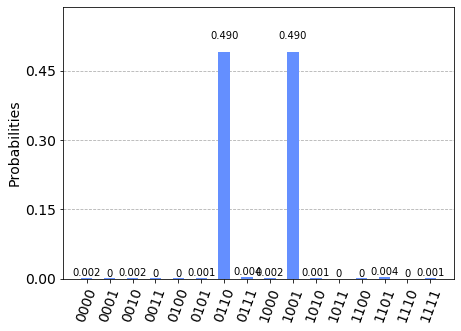

In [4]:
result, circuit = TspQaoaCircuit(2,2)
print(result)
plot_histogram(result)